# Coronavirus Reverse Engineering

## Genome Exploratory Analysis

Reverse engineering of the Coronavirus, in particular of SARS-CoV-2 which is the strain responsible of the current pandemic. Initially we explore the available genomic data and then we look at specific samples of SARS-CoV-2 where we define a reference case.

The information from NCBI ([example](https://www.ncbi.nlm.nih.gov/nuccore/MT233519.1)) in genbank files contains the full genome and a list of additional features, such as [CDS](https://en.wikipedia.org/wiki/Coding_region) (i.e. protein sequences), are annotated at the beginning. This additional information it's very helpful, but we show that sometimes the CDS list doesn't contain the mayority of the proteins in the genome (and in some cases there aren't any CDS at all, like GISAID fasta files). Even more, there is no convention about naming the CDS nor which one to include in the genbank file. For the particular case of coronaviruses, some includes orfa1/orf1b and others orfa1/orfab1 or with a different name, such as ppa1/ppab1.

At the end of the notebook we develop an algorithm to extract all [ORFs](https://en.wikipedia.org/wiki/Open_reading_frame) (which is fine-tuned for coronavirus genomes) that are potential CDS and create a database where genome regions can be accessed in a standardized manner through all the samples we collected (such as coding regions, 5'UTR, 3'UTR and intergene regions). 

This notebook also fetches data from NCBI automatically to reflect the latest information available. GISAID genomes are also processed if the files are available locally (but not included in this repository)

**TABLE OF CONTENTS**

* [Fetch Data](#section1)
* [Exploratory Data Analysis](#section2)
   * [Genome size](#section3) 
   * [Genome size over time](#section4)
   * [Host, country and genus distribution](#section5)
* [Genomic Database](#section6)
   * [Coding regions in the genome](#section7)
   * [Unknown ORFs](#section8)
   * [ORF finder algorithm](#section9)
   * [Genomic regions database](#section10)

In [1]:
from matplotlib import pyplot as plt

from IPython.display import display, HTML
from IPython.display import Markdown as md
from IPython.core.display import Image
import time
from sklearn.linear_model import LinearRegression

from reportlab.lib import colors
from reportlab.lib.units import cm

import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi

from Bio.Seq import Seq
from Bio import Entrez
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import seq3
from Bio import Align

import bisect 
import pandas as pd
import seaborn as sb
import numpy as np
import seaborn as sns
from scipy import stats
import math
import zlib

from intervaltree import Interval, IntervalTree
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

import datetime
import os
import lzma as xz

# data folders
root_folder = "./data/genbank/"
viruses = ["coronaviridae"]

# file periodically removed to update with the latest data
cache_vrs_file = ".cache_vrs.pkl" 
cache_cds_file = ".cache_cds.pkl" 
cache_regions_file = ".cache_regions.pkl" 

hidden_columns = ["sequence", "file_path", "strain", "collection_date"]
hidden_cds_columns = ["translation", "file_path", "location"]
hidden_regions_columns = ["id", "rna", "protein", "path"]

# GISAID data (not includided in the repo, you should add your own fasta file downloaded from the GISAID page)
gisaid_search_query = {"coronaviridae": ["./data/gisaid/"]}
gisaid_tokens_no_wa = 5
gisaid_tokens_no_host = 6
gisaid_tokens_with_host = 7

# 1. Fetch Data <a id="section1"></a>

Fetch the latest data from NCBI using keywords and a genome size range. 

In [2]:
base_folder = "./data/genbank/"

Entrez.email = 'coronaversing@gmail.com'
size_and_date = "(\"25000\"[SLEN] : \"35000\"[SLEN])"
genbank_search_query = {"coronaviridae": ["(\"Coronaviridae\"[Organism]) AND " + size_and_date]}

def fetch_gb(path, gid):
    handle = Entrez.efetch(db="nucleotide", id=gid, rettype="gb")
    local_file = open(path + "/" + gid + ".gb", 'w')
    local_file.write(handle.read())
    handle.close()
    local_file.close()

genome_files = genbank_search_query
viruses = genbank_search_query.keys()
    
count = 0
for vrs in viruses:
    
    data_folder = base_folder + vrs
    if not os.path.exists(data_folder):
        os.makedirs(data_folder)
    
    for keywords in genome_files[vrs]:
        handle = Entrez.esearch(db="nucleotide", retmax=5000, term=keywords, idtype="acc")
        record = Entrez.read(handle)
        ids = record["IdList"]
        print("[+] got", len(ids), "records")
        handle.close()

        for genbank_id in ids:
            file_name = data_folder + "/" + genbank_id + ".gb"
            count += 1
            if not os.path.exists(file_name):
                print("[+]  --- * fetching (", vrs, ")", file_name)
                downloaded = False
                tries = 0
                while not downloaded:
                    try:
                        fetch_gb(data_folder, genbank_id)
                        downloaded = True
                    except:
                        if tries == 5:
                            print("[+]  --- * couldn't get (", vrs, ")", genbank_id)
                            break
                        tries += 1
                        time.sleep(3)
                        pass

print("[+] Collected", count, " gb files")

[+] got 4206 records
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344963.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344962.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344961.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344960.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344959.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344958.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344957.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344956.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344955.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344954.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344953.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT344952.1.gb
[+]  --

[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345807.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345806.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345805.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345804.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345803.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345802.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345801.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345800.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345799.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT345798.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT320891.2.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT281530.2.gb
[+]  --- * fetching ( corona

[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325610.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325609.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325608.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325607.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325606.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325605.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325604.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325603.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325602.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325601.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325600.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT325599.1.gb
[+]  --- * fetching ( corona

[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326140.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326139.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326138.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326137.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326136.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326135.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326134.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326133.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326132.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326131.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326130.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326129.1.gb
[+]  --- * fetching ( corona

[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326038.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326037.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326036.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326035.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326034.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326033.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326032.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326031.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326030.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326029.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326028.1.gb
[+]  --- * fetching ( coronaviridae ) ./data/genbank/coronaviridae/MT326027.1.gb
[+]  --- * fetching ( corona

Let's take a quick look to what we have and put it all together in a data frame. We are only interested in complete genomes for now, or maybe samples with a high coverage of coding regions.

In [3]:
GENUS = ["deltacoronavirus", "gammacoronavirus", "alphacoronavirus", "betacoronavirus"]

def get_genomes():
    for vrs in viruses:    
        # define data frame structure for viruses
        feature_columns = ["country", "host", "strain", "collection_date"]
        sample_columns = ["id", "length", "date", "information", "description", 
                          "sequence", "file_path", "genus", "subgenus", "unknown"]
        total_columns = sample_columns + feature_columns
        vrs_frame = {i:list() for i in total_columns}

        # define data frame structure for CDS
        cds_feature_columns = ["protein_id", "product", "gene", "codon_start", "translation"]
        cds_sample_columns = ["oid", "type", "date", "file_path", "location", "start", 
                              "end", "length", "unknown"]
        cds_columns = cds_feature_columns + cds_sample_columns
        cds_frame = {i:list() for i in cds_columns}

        # loop over gb files
        data_folder = root_folder + vrs + "/"
        for filename in os.listdir(data_folder):
            if filename.endswith(".gb"): 
                for seq_record in SeqIO.parse(data_folder + filename, "genbank"):

                    # get genome sequence, under certain tolerance to unknown nucleotides
                    genome_sequence = seq_record.seq.upper()
                    
                    if not (seq_record.annotations['molecule_type'] == "RNA" or 
                            seq_record.annotations['molecule_type'] == "ss-RNA"):
                        continue 
                    
                    # get taxonomy
                    genus = "unknown"
                    subgenus = "unknown"
                    if "taxonomy" in seq_record.annotations:
                        taxonomy = seq_record.annotations["taxonomy"]
                        for i in range(0, len(taxonomy)):
                            if taxonomy[i].lower() in GENUS:
                                genus = taxonomy[i].lower()
                                if i + 1 < len(taxonomy):
                                    subgenus = taxonomy[i + 1].lower()
                                    if "unclassified" in subgenus:
                                        subgenus = "unknown"
                                    break
                        
                    # get several additional variables from genbank file featues (if available)
                    for ftrs in seq_record.features:
                        
                        # some metada of the sample
                        if ftrs.type == "source":                        
                            for var in feature_columns:                        
                                if var in ftrs.qualifiers:
                                    # sanitize country
                                    if var == "country":
                                        country = ftrs.qualifiers[var][0]
                                        country = country.split(":")[0]
                                        vrs_frame["country"].append(country.lower())
                                    # sanitize host
                                    elif var == "host":
                                        host = ftrs.qualifiers[var][0]
                                        host = host.split(";")[0]
                                        vrs_frame["host"].append(host.lower())
                                    else:
                                        vrs_frame[var].append(ftrs.qualifiers[var][0])
                                else:
                                    vrs_frame[var].append("unknown")

                        # collect cds data in a different dataframe
                        if "protein_id" in ftrs.qualifiers:                        
                            for var in cds_feature_columns:                        
                                if var in ftrs.qualifiers:
                                    if var == "gene":
                                        cds_frame[var].append(ftrs.qualifiers[var][0].upper())
                                    elif var == "product":
                                        cds_frame[var].append(ftrs.qualifiers[var][0].lower())
                                    else:
                                        cds_frame[var].append(ftrs.qualifiers[var][0])
                                else:
                                    cds_frame[var].append("unknown")

                            cds_frame["start"].append(ftrs.location.start)
                            cds_frame["end"].append(ftrs.location.end)
                            cds_frame["length"].append(len(ftrs.location))
                            cds_frame["location"].append(ftrs.location)
                            cds_frame["date"].append(seq_record.annotations["date"])

                            # cds data of the record
                            cds_frame["oid"].append(seq_record.id)
                            cds_frame["file_path"].append(data_folder + filename)
                            cds_frame["type"].append(ftrs.type)
                            
                            translation = cds_frame["translation"][-1]
                            unknown_fraction = float(translation.count("X")) / float(len(translation))
                            cds_frame["unknown"].append(unknown_fraction)

                    # compress virus genome to get an idea of the amount of information. 
                    info = 10000.0 / len(xz.compress(str(genome_sequence).encode('utf-8')))

                    # genome length
                    genome_length = len(genome_sequence)

                    # sample (virus) data
                    vrs_frame["id"].append(seq_record.id)
                    vrs_frame["date"].append(pd.to_datetime(seq_record.annotations["date"]))
                    vrs_frame["information"].append(info)
                    vrs_frame["length"].append(genome_length)
                    vrs_frame["sequence"].append(genome_sequence)
                    vrs_frame["file_path"].append(data_folder + filename)
                    vrs_frame["description"].append(seq_record.description)
                    
                    vrs_frame["genus"].append(genus)
                    vrs_frame["subgenus"].append(subgenus)

                    unknown_fraction = float(genome_sequence.count("N")) / float(len(genome_sequence))
                    vrs_frame["unknown"].append(unknown_fraction)
                    
            else:
                continue

        # GISAID data, in case is available locally
        for folder in gisaid_search_query[vrs]:
            data_folder = folder + vrs + "/"

            if not os.path.exists(data_folder):
                continue

            for filename in os.listdir(data_folder):
                full_path = data_folder + filename
                for record in SeqIO.parse(full_path, "fasta"):
                    genome_sequence = Seq(str(record.seq).upper().replace("-", "N"))

                    tokens = []
                    for i in record.description.split("/"):
                        tokens += i.split("|")
                    token_number = len(tokens)

                    host = "Homo Sapiens"
                    if token_number == gisaid_tokens_no_host:
                        strain = tokens[0]
                        country = tokens[1]
                        collection_date = tokens[3]
                        index = tokens[4]
                        date = tokens[5]
                    elif token_number == gisaid_tokens_with_host:
                        strain = tokens[0]
                        if any(x.isupper() for x in tokens[1]):
                            country = tokens[1]
                            host = tokens[2]
                        else:
                            host = tokens[1]
                            country = tokens[2]
                        collection_date = tokens[4]
                        index = tokens[5]
                        date = tokens[6]
                    elif token_number == gisaid_tokens_no_wa:
                        strain = tokens[0]
                        country = tokens[1]
                        collection_date = tokens[2]
                        index = tokens[3]
                        date = tokens[4]
                    else:
                        raise ValueError(record.description + " unexpected number of tokens")

                    # compress virus genome to get an idea of the amount of information. 
                    info = 10000.0 / len(xz.compress(str(genome_sequence).encode('utf-8')))

                    # genome length
                    genome_length = len(genome_sequence)

                    vrs_frame["country"].append(country.lower())
                    vrs_frame["host"].append(host.lower())
                    vrs_frame["strain"].append(strain)
                    vrs_frame["collection_date"].append(collection_date)

                    # sample (virus) data
                    vrs_frame["id"].append(index)
                    
                    # very weird stuff with GISAID dates
                    try:
                        submission_date = pd.to_datetime(date)
                    except:
                        dtoks = date.split("-")
                        date = dtoks[0] + "-" + str(int(dtoks[2])%2 + 1) + "-" + str(int(dtoks[1])%27 + 1)
                        submission_date = pd.to_datetime(date)

                    # more weird stuff with the date
                    if submission_date > datetime.date.today():
                        submission_date = datetime.date.today()
                    
                    vrs_frame["date"].append(submission_date)

                    vrs_frame["information"].append(info)
                    vrs_frame["length"].append(genome_length)
                    vrs_frame["sequence"].append(genome_sequence)
                    vrs_frame["file_path"].append(data_folder + filename)
                    vrs_frame["description"].append(record.description)
                    unknown_fraction = float(genome_sequence.count("N")) / float(len(genome_sequence))
                    vrs_frame["unknown"].append(unknown_fraction)

                    vrs_frame["genus"].append("unknown")
                    vrs_frame["subgenus"].append("unknown")
                    
    df = pd.DataFrame.from_dict(vrs_frame)
    cdf = pd.DataFrame.from_dict(cds_frame)

    return df, cdf

if os.path.isfile(cache_vrs_file):
    corona_orig = pd.read_pickle(cache_vrs_file)
    corona_cds = pd.read_pickle(cache_cds_file)
else:
    corona_orig, corona_cds = get_genomes()
    corona_orig.to_pickle(cache_vrs_file)
    corona_cds.to_pickle(cache_cds_file)

# set index
corona_orig = corona_orig.set_index("id")
corona_cds = corona_cds.set_index("protein_id")

# drop duplicates
corona_orig = corona_orig[~corona_orig.index.duplicated(keep='first')]
corona_cds = corona_cds[~corona_cds.index.duplicated(keep='first')]
        
display(HTML(corona_orig.drop(hidden_columns, axis=1).head().to_html()))
display(HTML(corona_cds.drop(hidden_cds_columns, axis=1).head().to_html()))

,length,date,information,description,genus,subgenus,unknown,country,host
id,,,,,,,,,
KX839246.1,28015,2017-09-07,1.256281,"Porcine epidemic diarrhea virus strain 85-7, complete genome",alphacoronavirus,unknown,0.000000,china,pig
MT326091.1,29710,2020-04-13,1.199616,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/UNKNOWN-UW-1832/2020, complete genome",betacoronavirus,sarbecovirus,0.000168,usa,homo sapiens
KX154689.1,30096,2017-04-30,1.165501,"Middle East respiratory syndrome coronavirus isolate Hu/Riyadh-KSA-10208/2016, complete genome",betacoronavirus,unknown,0.000000,saudi arabia,homo sapiens
MT345880.1,29871,2020-04-16,1.193887,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/ID-UW-4400/2020, complete genome",betacoronavirus,sarbecovirus,0.000502,usa,homo sapiens
MT186680.1,363,2020-03-13,42.372881,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/257182/human/2020/IRN nucleocapsid phosphoprotein (N) gene, partial cds",betacoronavirus,sarbecovirus,0.000000,iran,homo sapiens


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AST13214.1,polyprotein,ORF1,1,KX839246.1,CDS,07-SEP-2017,291,20624,20334,0.0
AST13215.1,spike protein,S,1,KX839246.1,CDS,07-SEP-2017,20620,24763,4143,0.0
AST13216.1,hypothetical protein,ORF3,1,KX839246.1,CDS,07-SEP-2017,24941,25406,465,0.0
AST13217.1,envelope protein,E,1,KX839246.1,CDS,07-SEP-2017,25386,25617,231,0.0
AST13219.1,membrane protein,M,1,KX839246.1,CDS,07-SEP-2017,25624,26317,693,0.0


# 2. Exploratory Data Analysis <a id="section2"></a>

## 2.1. Genome size <a id="section3"></a>

Let's look at the genome size and also the information distribution among all samples. The information column it's defined as the inverse of the amount of bytes of the genome compressed using lzma. It should be an indicator of the amount of information encoded in the sequence. A higher compression indicates a more ordered state (low entropy) which is equivalent to a high amount of information (think of a completely random sequence of base pairs, the compression ratio will be pretty high, since it doesn't have much information on it)

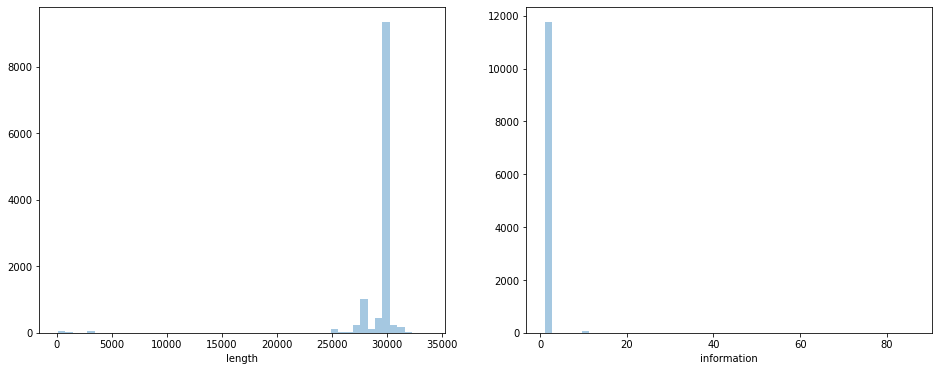

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona_orig["length"], kde=False, ax=axs[0]);
sns.distplot(corona_orig["information"], kde=False, ax=axs[1]);

There are a few outliers in the dataset, some genomes are less than ~25k base pairs and some higher than ~32k which is known to be the size range of coronaviruses genomes; most likely some are incomplete sequences. Let's take a closer look to this outliers and plot the genome size distribution.

In [5]:
mean = corona_orig["length"].mean()
std = corona_orig["length"].std()

md("$\overline{x} = %.2f$ *bps*"%mean)

$\overline{x} = 29249.79$ *bps*

In [6]:
md("${s} = %.2f$ *bps*"%std)

${s} = 3128.39$ *bps*

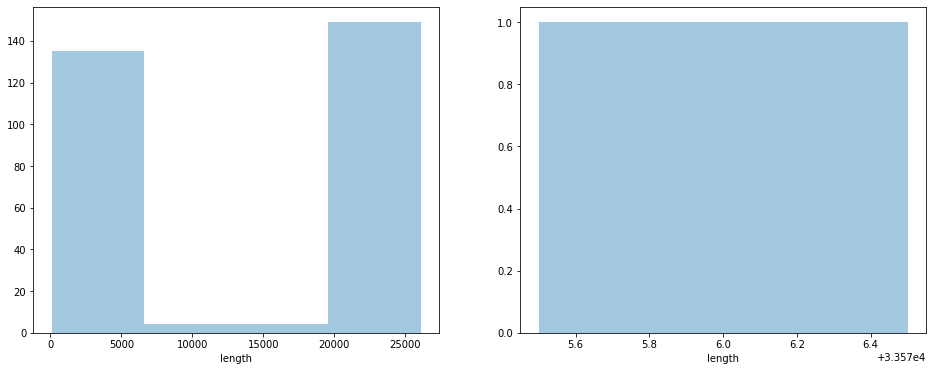

In [7]:
# let's use 1 std to detect outliers
cutoff_left = mean - std
cutoff_right = mean + std

outliers_low = corona_orig[corona_orig["length"] < cutoff_left]
outliers_high = corona_orig[corona_orig["length"] > cutoff_right]
    
if len(outliers_high) > 0:
    fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
    sns.distplot(outliers_high["length"], kde=False, ax=axs[1]);
    sns.distplot(outliers_low["length"], kde=False, ax=axs[0]);
else:
    plt.figure(figsize=(16, 6))
    sns.distplot(outliers_low["length"], kde=False);

There seems to be some anomalies for cases with a genome below ~16k. Let's look at this cases more closely.

In [8]:
bps_low_limit = 16000
outliers_low_values = outliers_low[outliers_low["length"] < bps_low_limit]
display(HTML(outliers_low_values.head(10).drop(hidden_columns, axis=1).to_html()))

,length,date,information,description,genus,subgenus,unknown,country,host
id,,,,,,,,,
MT186680.1,363,2020-03-13,42.372881,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/257182/human/2020/IRN nucleocapsid phosphoprotein (N) gene, partial cds",betacoronavirus,sarbecovirus,0.0,iran,homo sapiens
MT081068.1,1260,2020-02-20,18.796992,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/HS_194/human/2020/CHN nucleocapsid phosphoprotein (N) gene, complete cds",betacoronavirus,sarbecovirus,0.0,china,homo sapiens
KF294433.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-127 RNA-dependent RNA polymerase gene, partial cds",betacoronavirus,sarbecovirus,0.0,china,rhinolophus sinicus
KF294439.1,2795,2020-03-16,9.881423,"SARS-related bat coronavirus isolate Anlong-29 RNA-dependent RNA polymerase gene, partial cds",betacoronavirus,sarbecovirus,0.0,china,miniopterus schreibersii
KF294440.1,2795,2020-03-16,9.881423,"SARS-related bat coronavirus isolate Anlong-97 RNA-dependent RNA polymerase gene, partial cds",betacoronavirus,sarbecovirus,0.0,china,rhinolophus sinicus
KF294382.1,13631,2020-03-16,2.512563,"Anlong Ms bat coronavirus isolate Neixiang-32 orf1ab polyprotein gene, partial cds",alphacoronavirus,unknown,0.0,china,myotis davidii
KF294427.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-106 RNA-dependent RNA polymerase gene, partial cds",betacoronavirus,sarbecovirus,0.0,china,rhinolophus monoceros
KF294436.1,2795,2020-03-16,10.000000,"SARS-related bat coronavirus isolate Longquan-132 RNA-dependent RNA polymerase gene, partial cds",betacoronavirus,sarbecovirus,0.0,china,rhinolophus monoceros
KF294376.1,2780,2020-03-16,10.040161,"Lushi Ml bat coronavirus isolate Neixiang-27 RNA-dependent RNA polymerase gene, partial cds",alphacoronavirus,unknown,0.0,china,murina leucogaster


We can grab the top keywords used in the description of this submissions.

In [9]:
def top_keywords(df, column="description", n=5, stop_words=[]):
    descrps = []
    for descrp in df[column]:
        descrps.append(descrp)
    
    default_stopwords = ['the','about','an','and','are','at','be','can','for','from','if','in','is','it','of','on','or','that','this','to','you','your','with',]
    tfidf = TfidfVectorizer(max_features=10, stop_words=(default_stopwords + stop_words))
    tfidf.fit_transform(descrps)
    response = tfidf.transform(descrps)

    feature_array = np.array(tfidf.get_feature_names())
    tfidf_sorting = np.argsort(response.toarray()).flatten()[::-1]

    top_keyworkds = feature_array[tfidf_sorting][:n]

    display(HTML(pd.DataFrame(top_keyworkds, columns=["keywords"]).to_html()))

top_keywords(outliers_low_values)

,keywords
0,rna
1,partial
2,gene
3,isolate
4,coronavirus


These sequences are partial genomes or isolated genes, we can safely ignore this by setting a genome size cutoff at 16k. 

In [10]:
corona = corona_orig[corona_orig["length"] > bps_low_limit]

Additionally, let's explore the keywords in the description of the remaining submissions.

In [11]:
top_keywords(corona)

,keywords
0,2020
1,usa
2,03
3,hcov
4,19


Finally let's plot the genome size and information distribution among the remaining samples.

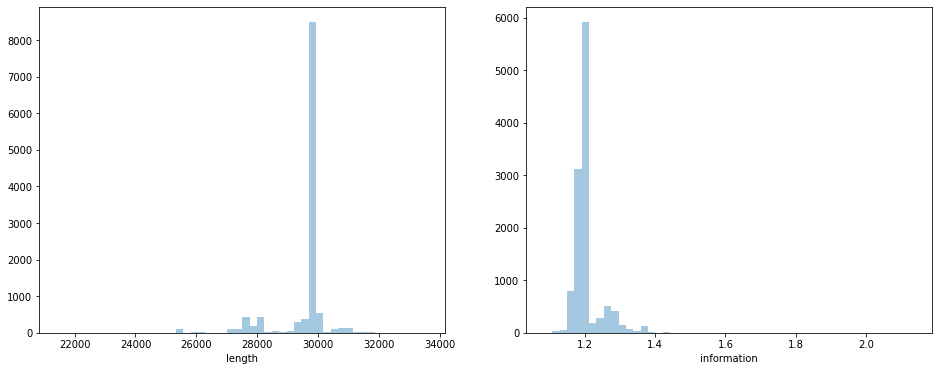

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(corona["length"], kde=False, ax=axs[0]);
sns.distplot(corona["information"], kde=False, ax=axs[1]);

By looking at the graphs, it seems that both the genome size and information have pretty much the same distribution. We should study the correlation between this two parameters and look for samples outside the general trend. Given the nature of viruses, one would expect that over time the amount of information is preserved regardless of the genome size. The compression rate might not be an accurate measure of that behavior, but it's useful to spot anomalies in the data.

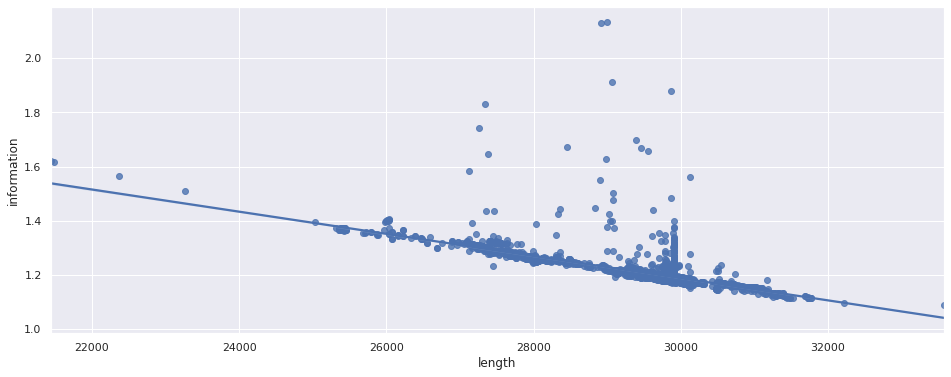

In [13]:
plt.figure(figsize=(16, 6))
sns.set(color_codes=True)
sns.regplot(x="length", y="information", data=corona[["length", "information"]]);

In [14]:
x = corona["length"].values.reshape(-1, 1)
y = corona["information"].values.reshape(-1, 1)
reg = LinearRegression().fit(x, y) 
information_outliers = (100 * (y - reg.predict(x)) / reg.predict(x)) > 5
display(HTML(corona[information_outliers].head(8).drop(hidden_columns, axis=1).to_html()))

,length,date,information,description,genus,subgenus,unknown,country,host
id,,,,,,,,,
KF430199.1,29604,2014-09-26,1.344809,UNVERIFIED: Human coronavirus HKU1 strain HKU1/human/USA/HKU1-14/2009 genomic sequence,betacoronavirus,unknown,0.092116,usa,homo sapiens
AY394984.1,29733,2004-01-29,1.325557,"SARS coronavirus HSZ-A, partial genome",betacoronavirus,sarbecovirus,0.122389,unknown,unknown
KF530271.1,28039,2014-09-26,1.385809,UNVERIFIED: Feline coronavirus strain feline/USA/236kid/2011 genomic sequence,alphacoronavirus,tegacovirus,0.106316,usa,felis catus
KF430196.1,29464,2014-09-26,1.668892,UNVERIFIED: Human coronavirus HKU1 strain HKU1/human/USA/HKU1-4/2005 genomic sequence,betacoronavirus,unknown,0.286655,usa,homo sapiens
LR757997.1,29388,2020-03-06,1.699524,"Wuhan seafood market pneumonia virus genome assembly, chromosome: whole_genome",betacoronavirus,sarbecovirus,0.344528,china,homo sapiens
KF530126.1,28306,2014-09-26,1.347709,UNVERIFIED: Feline coronavirus strain Felis catus/NLD/UU71/2010 genomic sequence,alphacoronavirus,tegacovirus,0.083057,netherlands,felis catus
HQ166910.1,29068,2016-07-25,1.397429,"Zaria bat coronavirus strain ZBCoV, partial genome",betacoronavirus,unknown,0.158387,nigeria,hipposideros commersoni
KF686345.1,29848,2014-09-26,1.282051,UNVERIFIED: Human coronavirus HKU1 strain HKU1/human/USA/HKU1-20/2010 genomic sequence,betacoronavirus,unknown,0.046837,usa,homo sapiens


There are a bunch of cases way above the general trend, showing much more information than the average genome. If we look carefully at the "unknown" column, most of this cases have a substantial amount of unknown nucleotides ("N" count) in the genome which artificially add some order to it (which is why we see it as more informative samples, although is not the case). If we filter this cases and look at genomes with at least %99 of the nucleotides sequenced, most of them fit into the general trend. 

,length,date,information,description,genus,subgenus,unknown,country,host
id,,,,,,,,,
KF294456.1,21444,2020-03-16,1.621271,"SARS-related bat coronavirus isolate Jiyuan-331 orf1ab polyprotein gene, complete cds",betacoronavirus,sarbecovirus,0.0,china,rhinolophus ferrumequinum
KF294455.1,21479,2020-03-16,1.617076,"SARS-related bat coronavirus isolate Anlong-111 orf1ab polyprotein and orf1a polyprotein genes, complete cds",betacoronavirus,sarbecovirus,0.0,china,rhinolophus rex
MG600028.1,29409,2018-11-08,1.276813,"Hainan hebius popei torovirus strain LPSC33749 1ab protein, spike protein, and hypothetical protein genes, complete cds",unknown,unknown,0.0,china,hebius popei


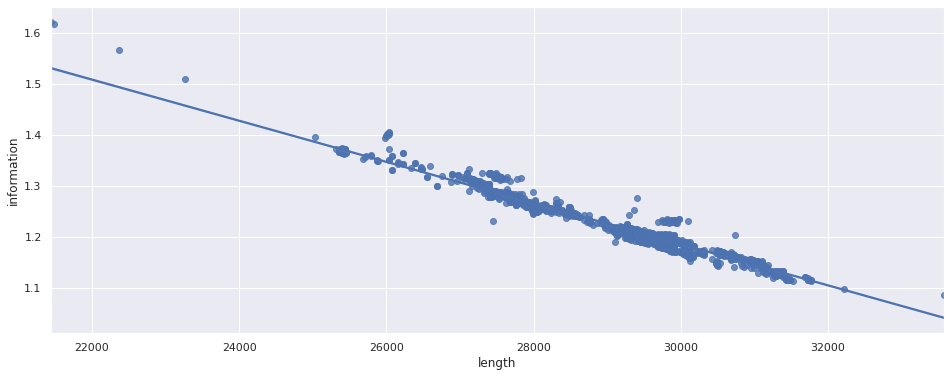

In [15]:
mostly_complete_genomes = corona[corona["unknown"] < 0.01]
plt.figure(figsize=(16, 6))
sns.set(color_codes=True)
sns.regplot(x="length", y="information", data=mostly_complete_genomes[["length", "information"]]);

x = mostly_complete_genomes["length"].values.reshape(-1, 1)
y = mostly_complete_genomes["information"].values.reshape(-1, 1)
reg = LinearRegression().fit(x, y) 
information_outliers = (100 * (y - reg.predict(x)) / reg.predict(x)) > 5
display(HTML(mostly_complete_genomes[information_outliers].drop(hidden_columns, axis=1).to_html()))

There are a few anomalies that have values above (5%) the fitted line, mostly for genomes genomes below 24k. These are actually cases of incomplete genomes, for example the SARS-related KF294456.1. By looking at the description it's actually a CDS of a pretty big gene (orf1ab) and not a complete genome. The divergence from the general trend could be explained by the removal of the non coding region of the genome. In any case, we'll have to take into account when comparing genomes that some samples might have only coding regions or have partial information of the genome. Since is a big chunk of genomic data, we want to keep this type of samples.

In [16]:
md("In total we collected $n = %i$ samples "%(len(corona)))

In total we collected $n = 11753$ samples 

## 2.2. Genome size over time <a id="section4"></a>

Another interesting thing to do, it's to analyze how the genome size changed over time, specially on the samples submitted the past month.


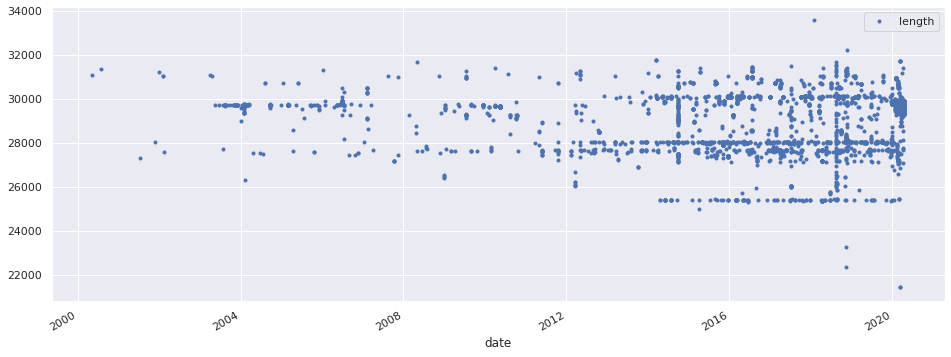

In [17]:
corona.plot(x="date", y=["length"], style='.', figsize=(16, 6));

It is clear that there is a diversity on the genome size of the submissions, which might be related that some sequences only represent coding regions and that we are dealing with various species that should be clustered for a deeper analysis per strain. A protein level analysis of the samples will be better to reveal similarities among all the genomes in the dataset. 

What about the samples submitted since december 2019?

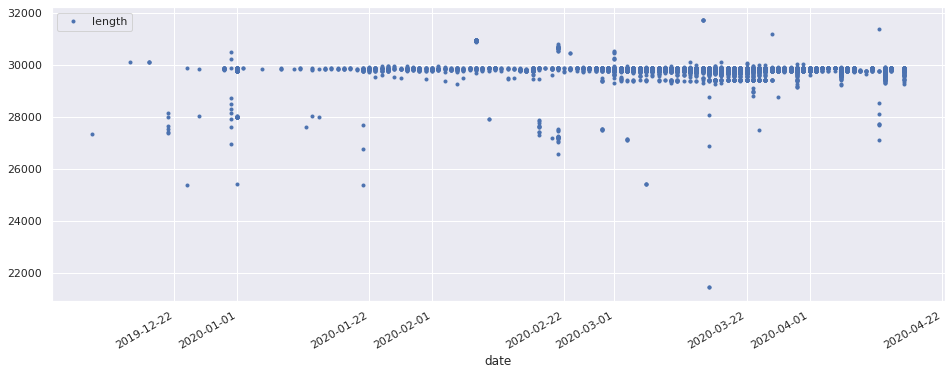

In [18]:
novel_corona = corona[corona["date"] > pd.to_datetime("2019-12-01")]
novel_corona.plot(x="date", y=["length"], style='.', figsize=(16, 6));

We know the genome size of the Wuhan virus has a size of 29903 bps. How many samples with that genome size do we have?

In [19]:
ncov = corona[corona["length"] == 29903]
display(HTML(ncov.head(10).drop(hidden_columns, axis=1).to_html()))

,length,date,information,description,genus,subgenus,unknown,country,host
id,,,,,,,,,
MT163718.1,29903,2020-03-10,1.190476,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/WA6-UW3/human/2020/USA, complete genome",betacoronavirus,sarbecovirus,0.000000,usa,homo sapiens
MT163719.1,29903,2020-03-10,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/WA7-UW4/human/2020/USA, complete genome",betacoronavirus,sarbecovirus,0.000000,usa,homo sapiens
MT334544.1,29903,2020-04-14,1.189910,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/UT-00028/2020, complete genome",betacoronavirus,sarbecovirus,0.000000,usa,homo sapiens
MT135043.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/233/human/2020/CHN, complete genome",betacoronavirus,sarbecovirus,0.000000,china,homo sapiens
MT328032.1,29903,2020-04-13,1.191611,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/GRC/10/2020, complete genome",betacoronavirus,sarbecovirus,0.000000,greece,homo sapiens
MT135044.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/235/human/2020/CHN, complete genome",betacoronavirus,sarbecovirus,0.000000,china,homo sapiens
MN908947.3,29903,2020-03-18,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",betacoronavirus,sarbecovirus,0.000000,china,homo sapiens
MT135041.1,29903,2020-03-04,1.188778,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/105/human/2020/CHN, complete genome",betacoronavirus,sarbecovirus,0.000000,china,homo sapiens
MT334529.1,29903,2020-04-14,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/UT-00010/2020, complete genome",betacoronavirus,sarbecovirus,0.000033,usa,homo sapiens


All of them were reported this year, consistently with what we know.

In [20]:
md("Total ncov samples $n = %i$ samples "%(len(ncov)))

Total ncov samples $n = 2871$ samples 

From all these SARS-CoV-2 samples, which one we should use as a reference for a genome variation analysis? We should look at the collection date (which is different from the date in the genbank annotations) and use the ones collected in december 2019.

In [21]:
reference_corona = corona[corona["collection_date"] == "Dec-2019"]
display(HTML(reference_corona.drop(hidden_columns, axis=1).to_html()))

,length,date,information,description,genus,subgenus,unknown,country,host
id,,,,,,,,,
MN908947.3,29903,2020-03-18,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",betacoronavirus,sarbecovirus,0.0,china,homo sapiens
NC_045512.2,29903,2020-03-13,1.189343,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome",betacoronavirus,sarbecovirus,0.0,china,homo sapiens


## 2.3. Host, country and genus distribution  <a id="section5"></a>

What about the host and country distribution? Let's plot that for all time samples and novel samples (submissions after december 2019)

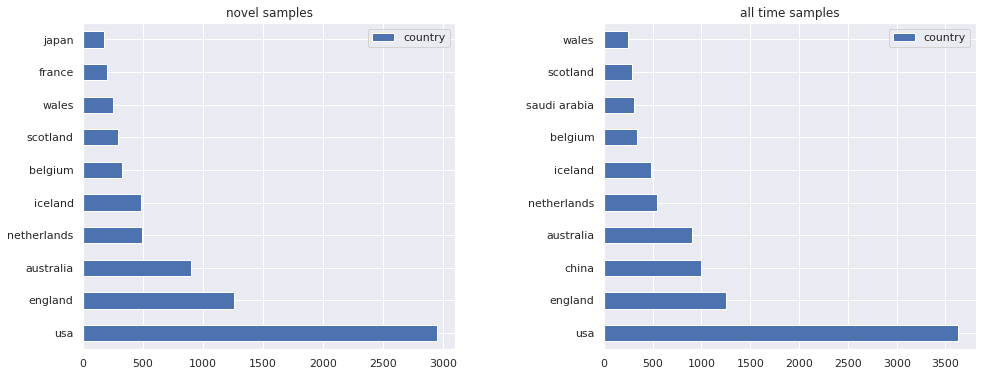

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

countries = pd.DataFrame(novel_corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

countries = pd.DataFrame(corona["country"].value_counts())
countries = countries[countries.index != "unknown"]
countries.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

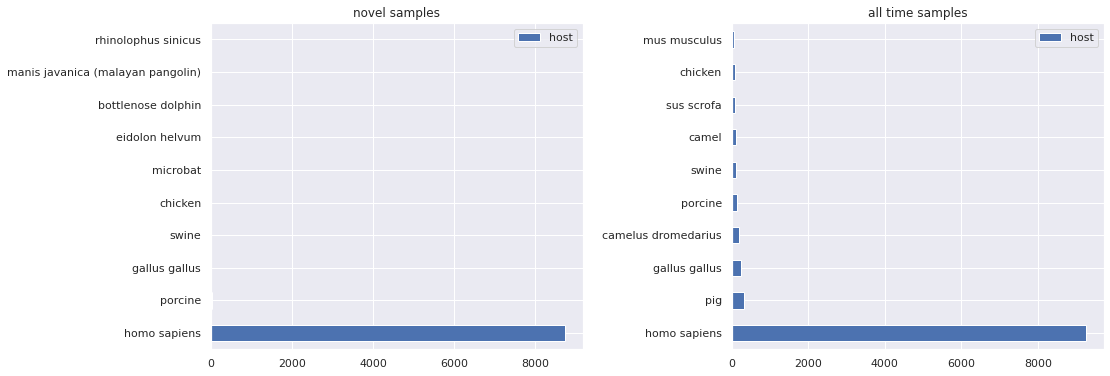

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

hosts = pd.DataFrame(novel_corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]
hosts.head(10).plot(kind = 'barh', ax=axes[0], title="novel samples");

hosts = pd.DataFrame(corona["host"].value_counts())
hosts = hosts[hosts.index != "unknown"]
hosts.head(10).plot(kind = 'barh', ax=axes[1], title="all time samples");

As expected, most samples are from humans. Let's take a look at the genus (and subgenus) distribution of our dataset.

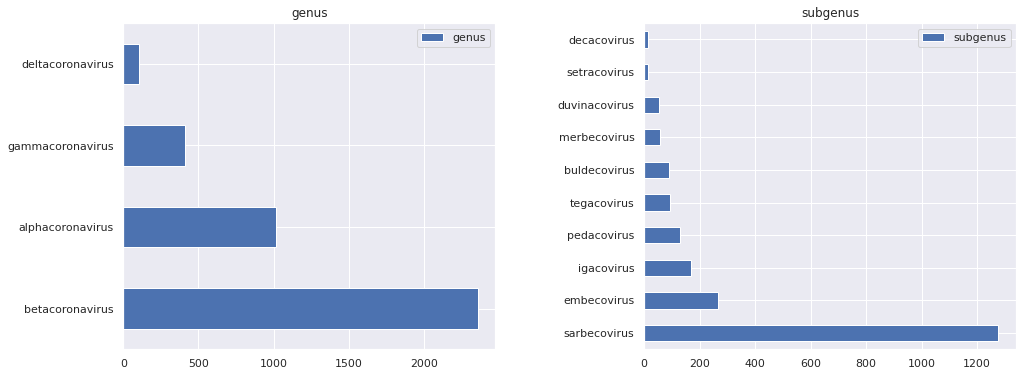

In [24]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
plt.subplots_adjust(wspace=0.4)

genus = pd.DataFrame(corona["genus"].value_counts())
genus = genus[genus.index != "unknown"]
genus.head(10).plot(kind = 'barh', ax=axes[0], title="genus");

subgenus = pd.DataFrame(corona["subgenus"].value_counts())
subgenus = subgenus[subgenus.index != "unknown"]
subgenus.head(10).plot(kind = 'barh', ax=axes[1], title="subgenus");

# 3. Genome sequence analysis <a id="section6"></a>

Now we have a pretty good picture of the data available. But what does this virus actually do? What does it look like? In order to have a better understanding we should analyze the coding sequences on the genome, which determines the sequence of amino acids of the proteins that the virus needs to replicate. Before that, we need to explore the distribution of coding sequences and understand how we can map each of one to the corresponding known proteins.

## 3.1. Coding regions in the genome <a id="section7"></a>

Let's focus on a single sample to analyze the distribution of coding regions in the genome to have a better understanding of the viral proteome. We'll look at the sample MN908947.3 which is the one we are going to use as a reference genome.

The features in the genbank file contains information of each protein and the translated sequence of aminoacids. This features type are called CDS and each one begins with a starting codon ('ATG' which corresponds to Met M). Let's take a look at each type=CDS annotation.

In [25]:
ncov = reference_corona.loc["MN908947.3"]
cds_ncov = corona_cds[corona_cds["oid"] == "MN908947.3"]
display(HTML(cds_ncov.drop(hidden_cds_columns, axis=1).to_html()))
display(HTML(ncov.drop(hidden_columns).reset_index().to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QHD43415.1,orf1ab polyprotein,ORF1AB,1,MN908947.3,CDS,18-MAR-2020,265,21555,21291,0.0
QHD43416.1,surface glycoprotein,S,1,MN908947.3,CDS,18-MAR-2020,21562,25384,3822,0.0
QHD43417.1,orf3a protein,ORF3A,1,MN908947.3,CDS,18-MAR-2020,25392,26220,828,0.0
QHD43418.1,envelope protein,E,1,MN908947.3,CDS,18-MAR-2020,26244,26472,228,0.0
QHD43419.1,membrane glycoprotein,M,1,MN908947.3,CDS,18-MAR-2020,26522,27191,669,0.0
QHD43420.1,orf6 protein,ORF6,1,MN908947.3,CDS,18-MAR-2020,27201,27387,186,0.0
QHD43421.1,orf7a protein,ORF7A,1,MN908947.3,CDS,18-MAR-2020,27393,27759,366,0.0
QHD43422.1,orf8 protein,ORF8,1,MN908947.3,CDS,18-MAR-2020,27893,28259,366,0.0
QHD43423.2,nucleocapsid phosphoprotein,N,1,MN908947.3,CDS,18-MAR-2020,28273,29533,1260,0.0


,index,MN908947.3
0,length,29903
1,date,2020-03-18 00:00:00
2,information,1.18934
3,description,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome"
4,genus,betacoronavirus
5,subgenus,sarbecovirus
6,unknown,0
7,country,china
8,host,homo sapiens


So we got 10 entries (of type CDS) that are coding sequences in the genome for polypeptides. I theory, we should get the same segments by looking at the genome sequence and extracting all nucleotides chains starting with an 'ATG' codon until a STOP codon is found. 

We identify (by the name of the genes) the structural (S,E,M and N) proteins of the virus described in the literature. The virus is enclosed by a membrane that includes the S (spike) protein, which will mediate attachment and entry into cells, M (membrane) protein, which is involved in organization of the nucleoprotein inside, and E (envelope) protein, which is a membrane channel involved in budding of the virus and may be incorporated into the virion during that process. The nucleoprotein inside includes many copies of the N (nucleocapsid) protein bound to the genomic RNA.

Here there is a nice ilustration of it. Hello virus.

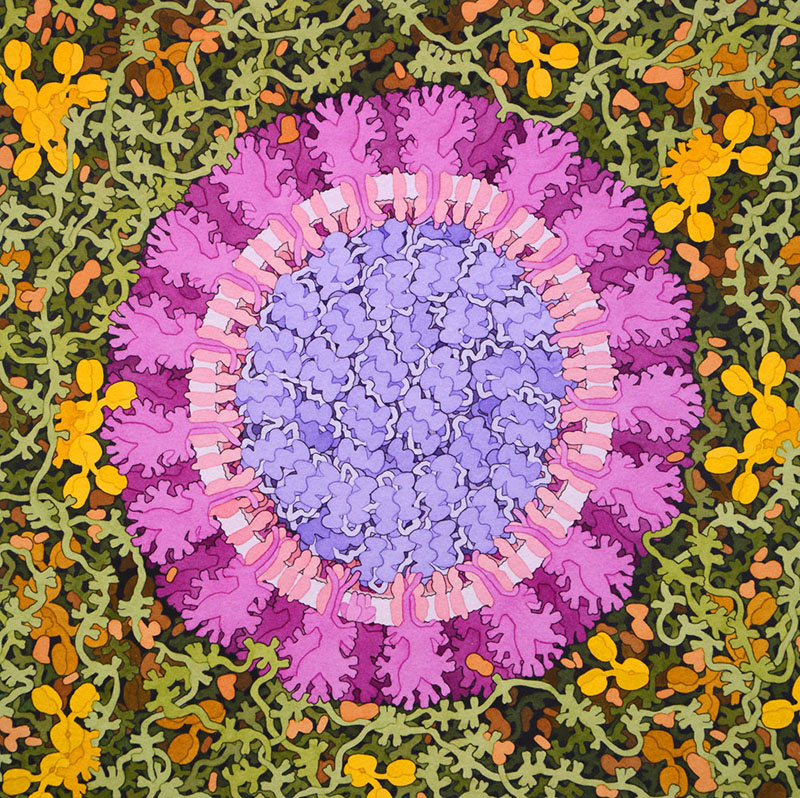

In [26]:
Image("data/images/coronavirus.jpeg")

Let's do this exercise to make sure everything is consistent. We are going to look for all possibles ORF which potentially can code a protein. Keep in mind we have to scan the genome in 3 different reading frames for start codons (ATG) until we find a stop codon. We are going to put a minimum amount of nucleotides (100) since we kind of know the size of the proteins. 

In [27]:
# function to get ORFs
def get_orfs(sequence, frame_shift = 0, start_codon = "ATG", min_nt = 100):
    stop_codons = ["TAG", "TGA", "TAA"]

    # go over the genome and find all start codons
    segments = []
    start = -1
    end = -1
    inside_segment = False

    for idx in range(frame_shift, len(sequence), 3):
        codon = sequence[idx:idx+3]

        if codon == start_codon and not inside_segment:
            start = idx
            inside_segment = True

        if codon in stop_codons and inside_segment:
            end = idx + 3

        if start != -1 and end != -1:
            if (end - start) + 3 > min_nt:
                segments.append((start, end))
            start = -1
            end = -1
            inside_segment = False

    segments.sort(key=lambda tup: tup[1] - tup[0], reverse=True)  # sorts in place

    return segments    

We should get all possible ORFs in different reading frames.

In [28]:
# get the genome sequence
ncov_genome = ncov["sequence"]
orfs = []

for frame_shift in [0, 1, 2]:
    orfs += get_orfs(ncov_genome, frame_shift=frame_shift)

print("[+] Got", len(orfs), " ORFs")

[+] Got 55  ORFs


Alright, so we got quite a lot of ORFs, much more than the amount listed on the genbank file. What could be the reason for this discrepancy? Maybe some protein sequences are not annotated in the file because are not expressed? Or could be that most of them are nested?

Before anything, let's make sure we got the proteins right and our results are consistent with the annotations on the genbank file. We should check that the CDS listed on the MN908947.3 table are in our list of ORFs.

In [29]:
# let's remove rows of the dataframe when we find one of the proteins in our set of ORFs
missing_proteins = cds_ncov

for orf in orfs:
    start = orf[0]
    end = orf[1]
    length = end - start
    protein = cds_ncov[(cds_ncov["start"] == start) & (cds_ncov["length"] == length)]
    if len(protein) > 0:
        missing_proteins = missing_proteins.drop(protein.index.values[0])

if len(missing_proteins) > 0:
    display(HTML(missing_proteins.drop(hidden_cds_columns, axis=1).to_html()))
else:
    print("[+] All covered")

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QHD43415.1,orf1ab polyprotein,ORF1AB,1,MN908947.3,CDS,18-MAR-2020,265,21555,21291,0.0
QHD43416.1,surface glycoprotein,S,1,MN908947.3,CDS,18-MAR-2020,21562,25384,3822,0.0


So we covered pretty much everything, except two cases. Do we have a coding segments of a similar sizes or at the same starting position?

In [30]:
def find_similar_cds(protein):
    target_start = protein["start"]
    target_start_left = target_start - 0.10 * target_start
    target_start_right = target_start + 0.10 * target_start

    target_length = protein["length"]
    target_length_left = target_length - 0.10 * target_length
    target_length_right = target_length + 0.10 * target_length

    matches = []
    for orf in orfs:
        start = orf[0]
        end = orf[1]
        length = 3 + (end - start)

        if length > target_length_left and length < target_length_right \
                and start > target_start_left and start < target_start_right:
                matches.append((start, end))

        if start == target_start:
                matches.append((start, end))
        
    return matches

So let's start analyzing the S protein (QHD43416.1) to see what's going on. 

In [31]:
s_protein = missing_proteins.loc["QHD43416.1"]
matches = find_similar_cds(s_protein)
for m in matches:
    print("[+] Found similar match", m, " of length ", m[1] - m[0])

[+] Found similar match (21535, 25384)  of length  3849


Interesting. So we found a CDS of similar size around the same starting point and exactly the same end position (STOP codon). So it seems that the initial sequence of the translated peptide it's not on the final protein? At least that's what the CDS suggest. This sounds a lot like a [signal peptide](https://en.wikipedia.org/wiki/Signal_peptide).

Let's extract the initial sequence of peptides to see what we are dealing with.

In [32]:
s_protein_sequence = s_protein["translation"]
odf = ncov_genome[21535:25384].translate(to_stop=True)

idx = odf.find(s_protein_sequence[:15])
cleavaged_peptide = odf[0:idx]
print(cleavaged_peptide)

MFLLTTKRT


So that's the signal peptide sequence that it's presumably removed from the S protein. It's composed of 9 aminoacids which is consistent with the difference we saw on the initial codon. That could be a possible explanation we could explore later. In any case, moving the origin of expression to 21562 should give us the same protein.

In [33]:
print("[+] Should be zero :", 21562 - (21535 + 3*9))
print("[+] And should be equal :", odf[idx:] == s_protein_sequence)

[+] Should be zero : 0
[+] And should be equal : True


And that's that. Now, let's take a look at the other CDS (orf1ab).

In [34]:
orf1ab_protein = missing_proteins.loc["QHD43415.1"]
matches = find_similar_cds(orf1ab_protein)
for m in matches:
    print("[+] Found similar match", m, " of length ", m[1] - m[0])

[+] Found similar match (265, 13483)  of length  13218


So this it's pretty much the opposite case of the S protein. We actually found a match with the same starting position, but almost half of the size. So what's going on here? Actually it's a bit more tricker than before. Luckily I've been reading a bit about the virus and orf1ab it's a polyprotein which is translated by a -1 PRF mechanism ([Programmed -1 Ribosomal Frameshifting](https://en.wikipedia.org/wiki/Ribosomal_frameshift)).

A ribosome starts translating one ORF until a signal in the RNA directs it to shift into an alternative downstream ORF which is in a -1 phase relative to the initiating upstream ORF.  The virus utilizes a slippery sequence (5′-UUUAAAC-3′) and an RNA pseudoknot that cause ribosomal frameshifting from the one reading frame into the other. 

Basically the segment we obtained by looking at ORFs is what it's called orf1a. In most cases, the ribosome unwinds the pseudoknot structure, and continues translation until it encounters the orf1a stop codon expressing the polypeptide we found (from 265 to 13483). Occasionally the pseudoknot blocks the ribosome from continuing the elongation, causing it to pause on the slippery sequence, changing the reading frame by moving back one nucleotide (a −1 frameshift) and the ribosome is able to melt the pseudoknot structure resulting in the translation of orf1ab. Pretty crazy stuff.

Presumably this plays a role in regulating the expression of the orf1ab with respect to the orf1a polypetide. Let's look for the slippery sequence. It should be before the STOP codon at 13483.

In [35]:
orf1a_start = 265
orf1a = ncov_genome[orf1a_start:13483]
slippery_sequence = "TTTAAAC"

slippery_when_wet = orf1a.find(slippery_sequence)
for o in range(0, len(orf1a)):
    if orf1a[o:o+7] == slippery_sequence:
        idx = orf1a_start + o
        print("[+] Found sequence", orf1a[o:o+7], "at", idx, "-", idx + len(slippery_sequence))
    o += 3

[+] Found sequence TTTAAAC at 1663 - 1670
[+] Found sequence TTTAAAC at 6084 - 6091
[+] Found sequence TTTAAAC at 6744 - 6751
[+] Found sequence TTTAAAC at 13461 - 13468


So we found a few. Ideally,  we can analyze the secondary structure of the RNA downstream from the slippery sequence to make a prediction of a RNA pseudoknot. Since we already know it's the last one, we can leave that analysis for some other time.

Let's run a final check to make sure we have all covered.

In [36]:
orf1b = get_orfs(ncov_genome[13467:], frame_shift=0, start_codon=ncov_genome[13467:13470])[0]

shifted_orf1ab = ncov_genome[orf1a_start:13468] + ncov_genome[13467:13467 + orf1b[1]]
orf1ab_protein_sequence = orf1ab_protein["translation"]

shifted_orf1ab_protein = shifted_orf1ab.translate(to_stop=True)

print("[+] Should be zero :", len(shifted_orf1ab_protein) - len(orf1ab_protein_sequence))
print("[+] And should be equal :", str(shifted_orf1ab_protein) == str(orf1ab_protein_sequence))

center = 13467
shifted = ncov_genome[:13468] + ncov_genome[13467:13467 + orf1b[1]]

print()
print(" - Frame shift")
print("--------------------------->  <--------")
for i in range(center - 7*3, center + 7*3, 3):
    print(ncov_genome[i:i+3], end=' ')
print()
for i in range(center - 7*3, center + 7*3, 3):
    print(shifted[i:i+3], end=' ')

[+] Should be zero : 0
[+] And should be equal : True

 - Frame shift
--------------------------->  <--------
TGA TGC ACA ATC GTT TTT AAA CGG GTT TGC GGT GTA AGT GCA 
TGA TGC ACA ATC GTT TTT AAA CCG GGT TTG CGG TGT AAG TGC 

Finally, we can plot the CDS distribution on the genome. 

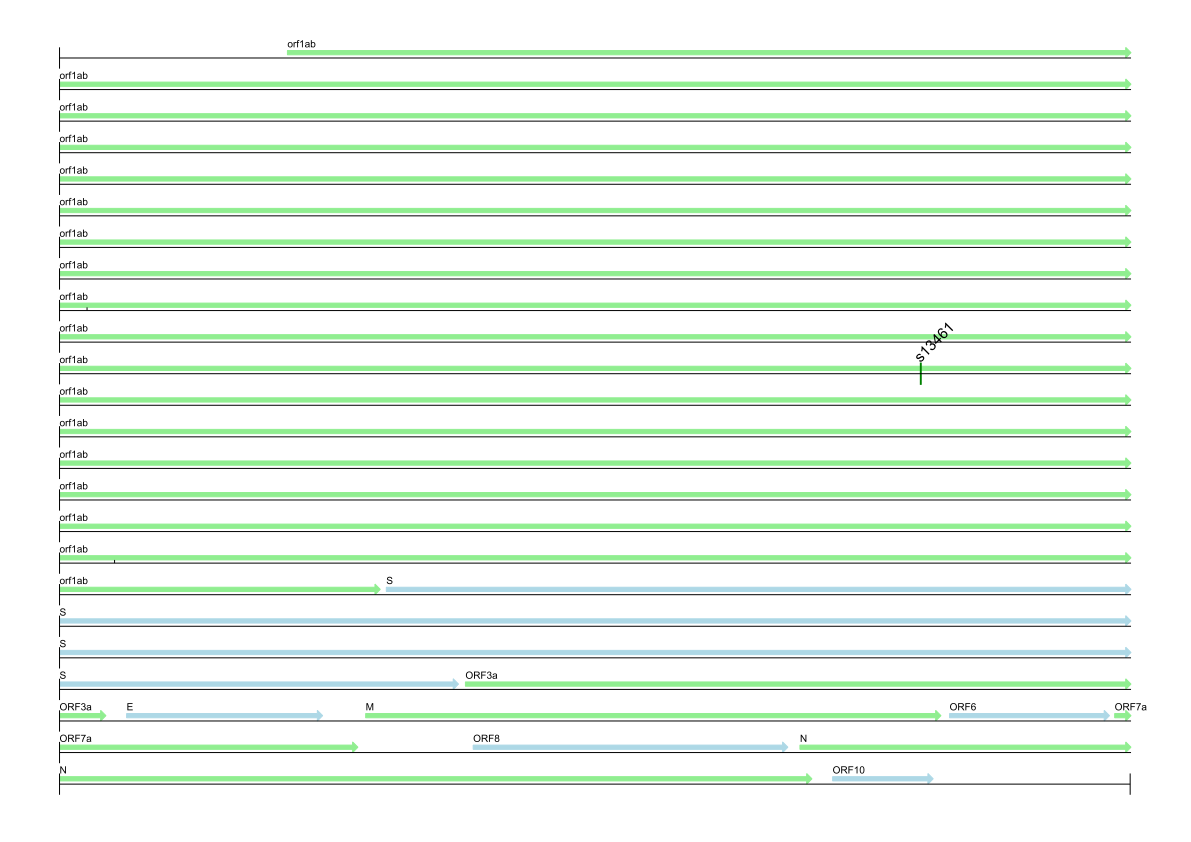

In [37]:
def plot_genome(record, segments, final_orfs=False):
    gd_diagram = GenomeDiagram.Diagram(record.id)
    gd_track_for_features = gd_diagram.new_track(1, name="Annotated Features")
    gd_feature_set = gd_track_for_features.new_set()

    for feature in record.features:
        if feature.type != "gene":
            #Exclude this feature
            continue
        if len(gd_feature_set) % 2 == 0:
            color = colors.lightgreen
        else:
            color = colors.lightblue
        gd_feature_set.add_feature(feature, sigil="ARROW", color=color, label=True, label_size = 10, label_angle=0)

        
    for seg in segments:
        feature = SeqFeature(FeatureLocation(seg[0], seg[0] + 1))
        gd_feature_set.add_feature(feature, color=colors.green, name="s" + str(seg[0]),
                                   label=True, label_size = 15)

    if final_orfs:
        for seg in segments:
            feature = SeqFeature(FeatureLocation(seg[1], seg[1] + 1))
            gd_feature_set.add_feature(feature, color=colors.red, name="f" + str(seg[0]),
                                       label=True, label_size = 15)
        
        
    gd_diagram.draw(format="linear", fragments=24,
            start=0, end=len(record))
        
    figure = "data/images/genome.png"
    gd_diagram.write(figure, "png")
    
    return figure        

record = SeqIO.read(ncov["file_path"], "genbank")
figure = plot_genome(record, [(13461, 13468)])
Image(figure)

We still have a few more things to explain regarding the orf1ab polyprotein (replicase complex). Coronavirus genome replication and transcription takes place in membranes inside the cell and involves processes of RNA synthesis that are mediated by the viral replicase. The replicase complex is believed to be comprised of up to 16 viral subunits (which are non structural proteins, NSPs) and a number of cellular proteins.

So, what is the distribution of the NSPs in the orf1ab gene? 

Also, what should we do with the ORFs we found that are not defined as CDS in the genbank file? Let's take a better look to those before moving to the orfab1 gene. 

## 3.2. Unknown ORFs <a id="section8"></a>

Previously we identified a bunch of ORFs in the genome (55), which are coding sequences that potentially might be translated as proteins. We verified that the CDS data annotated in the genbank file is consistent with the coding segments we found, but we have much more potential segments than the 10 listed in the file. What are these? We should try to plot them in the genome and do a visual analysis. 

Maybe most of them are overlapped and we should keep only the wider segments and remove the nested ORFs? Keep in mind we'll have to slightly correct to ORF based on the results we found before (i.e. the framehifted translation of orf1ab and the removal of a signal peptide of the S protein)

In [38]:
# get the genome sequence
ncov_genome = ncov["sequence"]
original_orfs = []

for frame_shift in [0, 1, 2]:
    original_orfs += get_orfs(ncov_genome, frame_shift=frame_shift)
        
print("[+] Got", len(original_orfs), " ORFs")

[+] Got 55  ORFs


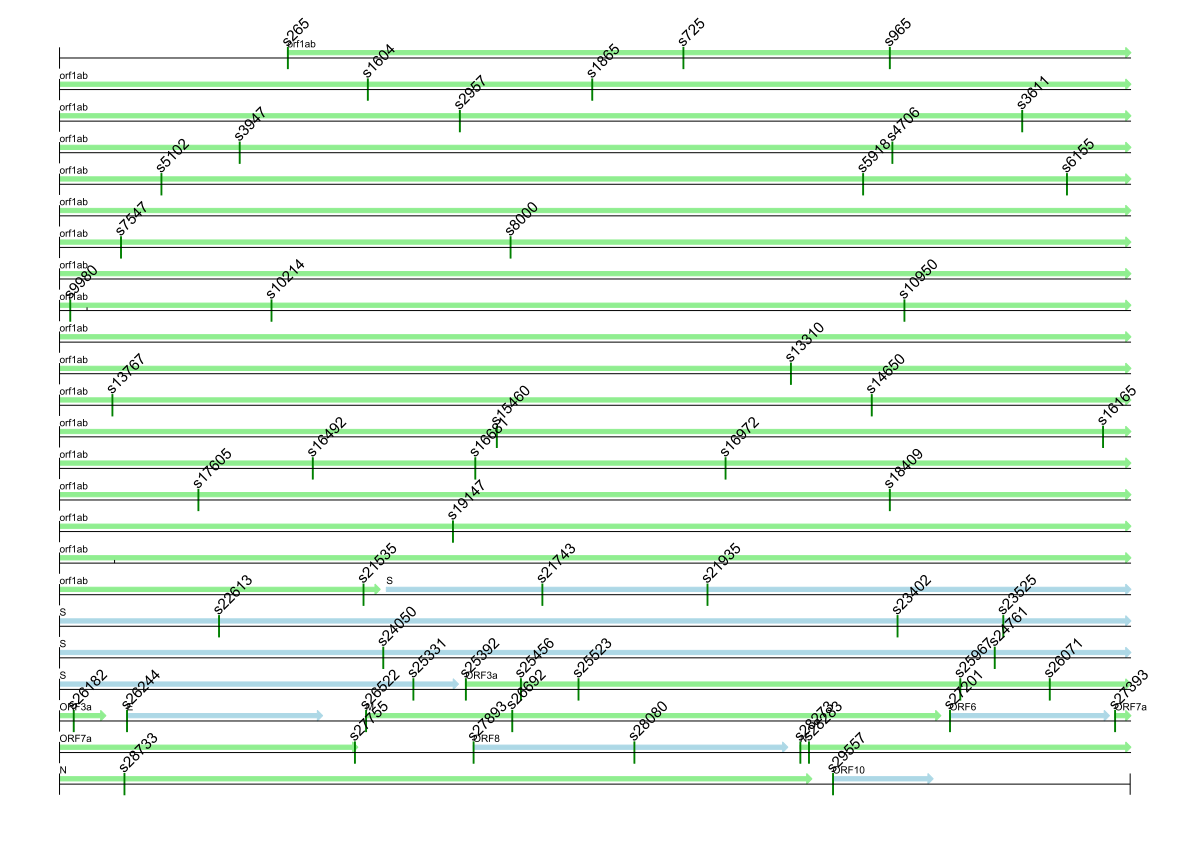

In [39]:
figure = plot_genome(record, original_orfs)
Image(figure)

So yes, as expected all of them are kind of nested within the wider coding segments. At this point I'm not really sure what would prevent translation of the subgenomic RNA starting from some of these ORFs. I would guess that, in order to maximize the amount of information in the genome, from an evolutionary perspective, the coding segments size would be maximized while minimizing the space between them (assuming the translation is done continuously through the genome). But we can't rule out cases where there are nested ORFs that are also expressed.

In that case, we should get rid of nested ORFs that are included in wider ones, and later we can analyze coding regions within other coding regions.

In [40]:
def remove_nested_orfs(orfs):
    # first let's order everything by starting position
    final_orfs = orfs.copy()
    final_orfs.sort(key=lambda r: r[0])
    keys = [r[0] for r in final_orfs]

    for sgs in final_orfs:
        # let's loop over every segment
        current_start = sgs[0]
        current_end = sgs[1]

        # remove all segments nested into this one
        while True:
            nxt = bisect.bisect_right(keys, current_start)
            if nxt != len(keys):
                nxt_start = nxt
                nxt_end = final_orfs[nxt][1]
                
                if nxt_start == current_start and nxt_end >= current_end:
                    keys.remove(keys[nxt])
                    final_orfs.remove(final_orfs[nxt])
                    
                if nxt_start > current_end or nxt_end > current_end:
                    break
                
                if nxt_end <= current_end:
                    keys.remove(keys[nxt])
                    final_orfs.remove(final_orfs[nxt])
            else:
                break

    return final_orfs

final_orfs = remove_nested_orfs(original_orfs)
print("[+] Got", len(final_orfs), " ORFs")

[+] Got 14  ORFs


OK, this is much closer than the amount of CDS we know. What about the distribution on the genome? Let's also remove from our set the CDS defined on genbank and plot the remaining segments (a green line represents the starting codon(s) and the red line is the final(f)).

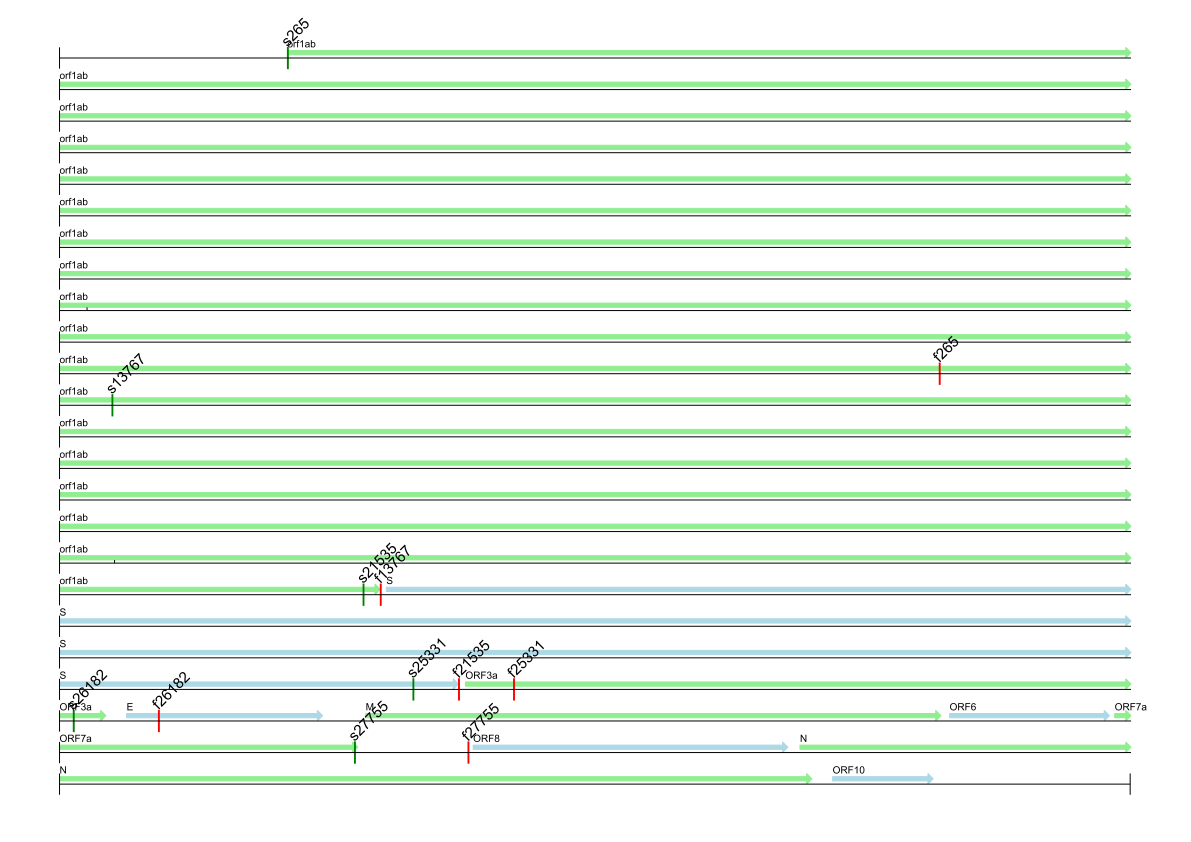

In [41]:
unknown_orfs = final_orfs.copy()

for orf in final_orfs:
    start = orf[0]
    end = orf[1]
    protein = cds_ncov[(cds_ncov["start"] == start) & (cds_ncov["end"] == end)]
    if(len(protein) > 0):
        unknown_orfs.remove(orf)

# green markers is where the ORF starts and red markers is when it ends
figure = plot_genome(record, unknown_orfs, final_orfs=True)
Image(figure)

In [42]:
for seg in unknown_orfs:
    print ("ORF : ", seg)

ORF :  (265, 13483)
ORF :  (13767, 21555)
ORF :  (21535, 25384)
ORF :  (25331, 25448)
ORF :  (26182, 26281)
ORF :  (27755, 27887)


Much better, now is more consistent. From an information maximization point of view, makes sense that some ORFs should be removed (of course under the assumption that nested ORFs are not expressed). Those are (25331, 25448) and (26182, 26281) which are interleaved between other much bigger genes. Probably we can come up with an algorithm to automatically remove those segments, while maximizing the coding region.

Another thing is the ORF at (21535, 25384). Prevously we said there was a potential signal peptide that was removed. Looking at this graph there might be another explanation. The codon at 21535 it's located before the final codon of ORF (13767, 21555) at 20 nucleotides upstream. Most likely the expression of the S protein begins after the expression of orfab1 finishes. We should study the RNA replication within the cell to have a better picture of this.

Now there are some other interesting cases here. The ORF (27755, 27887) seems to be slightly interleaved between the other genes, but almost covering the space between. The ORF7a end point it's at 27759 a few nucleotides downstream of ORF-27755. Could a possible ORF that is expressed, since it almost cover a blank space? Or maybe there is an 'ATG' codon downstream 27755 just like the S case before?

Let's take a look at this sequence of aminoacids.

In [43]:
orf_27755 = ncov_genome[27755:27887].translate(to_stop=True)
print(orf_27755)

MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA


So there isn't a starting codon after the initial one (27755). What if we google this sequence? I actually found quite a few references, including one in an NCBI SARS-CoV-2 sample (MN996531.1) as a NS7b protein. We should probably have that one in our database.

In [44]:
other_ncov_proteins = corona_cds[corona_cds["oid"] == "MN996531.1"]
ns7b =  other_ncov_proteins[other_ncov_proteins["gene"] == "NS7B"]
ns7b_sequence = ns7b["translation"].values[0]

print("[+] Exact sequence match :", ns7b_sequence == orf_27755)

display(HTML(ns7b.drop(hidden_cds_columns, axis=1).to_html()));

[+] Exact sequence match : True


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QHR63296.1,nonstructural protein ns7b,NS7B,1,MN996531.1,CDS,18-MAR-2020,27742,27874,132,0.0


So there go. Also for this case, the end of NS7a it's exactly 4 nucleotides downstream than the starting codon of NS7b. So how many of samples do we have with this particular protein?

In [45]:
samples_with_ns7b = corona_cds[corona_cds["translation"].str.contains(ns7b_sequence)]
display(HTML(samples_with_ns7b.drop(hidden_cds_columns, axis=1).to_html()));

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QIZ13783.1,orf7b,ORF7B,1,MT326091.1,CDS,13-APR-2020,27563,27695,132,0.0
QJA17390.1,orf7b,ORF7B,1,MT345880.1,CDS,16-APR-2020,27708,27840,132,0.0
QIZ16443.1,orf7b,ORF7B,1,MT325635.1,CDS,13-APR-2020,27755,27887,132,0.0
QJA17426.1,orf7b,ORF7B,1,MT345883.1,CDS,16-APR-2020,27726,27858,132,0.0
QIU81171.1,orf7b,ORF7B,1,MT293176.1,CDS,06-APR-2020,27724,27856,132,0.0
QIZ13341.1,orf7b,ORF7B,1,MT326054.1,CDS,13-APR-2020,27607,27739,132,0.0
QIZ16395.1,orf7b,ORF7B,1,MT325631.1,CDS,13-APR-2020,27755,27887,132,0.0
QIX13777.1,orf7b,ORF7B,1,MT322402.1,CDS,11-APR-2020,27750,27882,132,0.0
QIU81099.1,orf7b,ORF7B,1,MT293170.1,CDS,06-APR-2020,27641,27773,132,0.0


Quite a lot. So it really looks like a protein that is missing in the CDS annotations.

So what does this tell us? At least to me, that we can't really trust much the CDS features annotated on a genbank file. Those might have some protein or coding regions missing for whatever reason.

We should develop an algorithm to extract CDSs from the genome itself and run it over all the samples we have and spot for inconsistencies. We should take special care on the orfab1 protein, and compare the reading frame of 2 CDS (265, 13483) and (13767, 21555) to do the proper merging filling the missing gap (which should contain the slippery RNA sequence).

Let's look at the other reference SARS-CoV-2 sample we found from December 2019.

In [46]:
ncov1 = reference_corona.loc["NC_045512.2"]
cds_ncov1 = corona_cds[corona_cds["oid"] == "NC_045512.2"]
display(HTML(cds_ncov1.drop(hidden_cds_columns, axis=1).to_html()))
display(HTML(ncov1.drop(hidden_columns).reset_index().to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
YP_009724389.1,orf1ab polyprotein,ORF1AB,1,NC_045512.2,CDS,13-MAR-2020,265,21555,21291,0.0
YP_009725297.1,leader protein,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,265,805,540,0.0
YP_009725298.1,nsp2,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,805,2719,1914,0.0
YP_009725299.1,nsp3,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,2719,8554,5835,0.0
YP_009725300.1,nsp4,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,8554,10054,1500,0.0
YP_009725301.1,3c-like proteinase,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,10054,10972,918,0.0
YP_009725302.1,nsp6,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,10972,11842,870,0.0
YP_009725303.1,nsp7,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,11842,12091,249,0.0
YP_009725304.1,nsp8,ORF1AB,unknown,NC_045512.2,mat_peptide,13-MAR-2020,12091,12685,594,0.0


,index,NC_045512.2
0,length,29903
1,date,2020-03-13 00:00:00
2,information,1.18934
3,description,"Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome"
4,genus,betacoronavirus
5,subgenus,sarbecovirus
6,unknown,0
7,country,china
8,host,homo sapiens


So in this case we have a bit more information about the orf1ab gene. It seems that the NSP and other proteins within the polyprotein are defined here as 'mat_peptide's entries. This might be very useful in order to find cleavage sites in other samples. There must be some kind of hidden pattern in the orf1ab sequence that reveals those sites.

Before going there, let's get the list of ORFs on this sample.

In [47]:
ncov1_genome = ncov1["sequence"]
orfs = []

for frame_shift in [0, 1, 2]:
    orfs += get_orfs(ncov1_genome, frame_shift=frame_shift)

final_orfs = remove_nested_orfs(orfs)

unknown_orfs = final_orfs.copy()

for orf in final_orfs:
    start = orf[0]
    end = orf[1]
    protein = cds_ncov[(cds_ncov["start"] == start) & (cds_ncov["end"] == end)]
    if(len(protein) > 0):
        unknown_orfs.remove(orf)
        
for seg in unknown_orfs:
    print ("ORF : ", seg)

ORF :  (265, 13483)
ORF :  (13767, 21555)
ORF :  (21535, 25384)
ORF :  (25331, 25448)
ORF :  (26182, 26281)
ORF :  (27755, 27887)


Maybe this samples have the same genome?

In [48]:
print("[+] Same genome?", ncov1_genome == ncov_genome)

[+] Same genome? True


Indeed. But this other sample (NC_045512.2) has additional information about the NSPs in the polyprotein. Pretty cool. 

## 3.3. ORF finder algorithm <a id="section9"></a>

Before moving to a different topic we should finish this analysis with al algorithm to find all the ORFs given the genome of the virus. We should run the algorithm over all the samples we collected and compare our results with the CDS features genbank files. In particular, we'll be interested in knowing if we captured all the annotated CDS.

In general lines, the algorithm should:

* Find all possible ORFs (with our function get_orfs).
* Remove nested ORFs completely included in a wider one
* Remove ORFs that overlap between two genes, but that do not provide a substantial additional coding region. 
* We are going to include the initial peptide sequence on the "S" protein and the same for all other ORFs with a subtle overlap.

In [49]:
def extract_orfs(genome):
    # if this portion of the ORF falls into a non coding region, we keep it
    non_coding_overlapping_threshold = 0.9
    
    orfs = []

    for frame_shift in [0, 1, 2]:
        orfs += get_orfs(genome, frame_shift=frame_shift)

    # remove nested ORFs
    selected_orfs = remove_nested_orfs(orfs)

    # join first 2 ORFs (into orf1ab) and leave orf1a 
    selected_orfs.sort(key=lambda r: r[0])
                    
    orfs = IntervalTree.from_tuples(selected_orfs)

    while True:
        final_orfs = []

        for orf in orfs:
            overlapped = orfs.overlap(orf)
            overlapped.remove(orf)

            for ovp in overlapped:
                if ovp[0] == orf[0]:
                    overlapped.remove(ovp)
                    break

            if len(overlapped) == 0:
                continue

            coding_overlapping = 0.0

            for ovp in overlapped:
                
                if ovp[1] > orf[0] and ovp[0] < orf[0]:                            
                    coding_overlapping += (ovp[1] - orf[0]) / (orf[1] - orf[0])
                if ovp[0] < orf[1] and ovp[1] > orf[1]: 
                    coding_overlapping += (orf[1] - ovp[0]) / (orf[1] - orf[0])

            non_coding_overlapping = 1.0 - coding_overlapping
            final_orfs.append((non_coding_overlapping, orf))

        if len(final_orfs) == 0:
            break
            
        final_orfs.sort(key=lambda tup: tup[0])  
        if final_orfs[0][0] > non_coding_overlapping_threshold:
            break
        else:
            orfs.remove(final_orfs[0][1])

    return sorted(selected_orfs)

Now let's run the function and compare with the list of CDSs.

In [50]:
cds_ncov1_protein = cds_ncov1[cds_ncov1["type"] == "CDS"]
missing_proteins = cds_ncov1_protein.copy()

orfs = extract_orfs(ncov1_genome)

for orf in orfs:
    start = orf[0]
    end = orf[1]
    proto = cds_ncov1_protein[(cds_ncov1_protein["start"] == start) & 
                              (cds_ncov1_protein["end"] == end)]
    if(len(proto) > 0):
        missing_proteins = missing_proteins.drop(proto.index.values[0])

if(len(missing_proteins) > 0):
    display(HTML(missing_proteins.drop(hidden_cds_columns, axis=1).to_html()))
else:
    print("[+] All covered")

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
YP_009724389.1,orf1ab polyprotein,ORF1AB,1,NC_045512.2,CDS,13-MAR-2020,265,21555,21291,0.0
YP_009724390.1,surface glycoprotein,S,1,NC_045512.2,CDS,13-MAR-2020,21562,25384,3822,0.0


We find differences, because we are including the initial codon in the S protein that falls into the 3' end of the orfab1 gene and we are not joining the orf1a and orf1b gene yet.

## 3.4. Genomic regions database <a id="section10"></a>

Given this generic method we have to extract potential coding ORFs, or at least the known ones in the virus genome, we would like to create a final dataframe to access this information efficiently in a standardized manner. We saw that CDS entries might not contains all the coding regions in the genome. Also some genbank files might call this CDS with different names for example ppa1ab instead of orfab1. Others prefer to includes the orf1a and orf1b gene instead of the orfa1 and orf1ab one. I prefer the former, since we need a more precise analysis for joining them. We'll leave that for later, once we collected all ORFs in the genome.

This lack of standardization makes difficult a systematic study of the genome components across all the samples we collected. For example, we would like to make a query for all the S proteins in the genome dataset of a given length or between a range of dates.

To solve this problem, we are going to create a dataframe with entries that represents regions in the genome of essentially the following types:

* "5'URT" and "3'URT" regions
* "ORF" regions : all potential coding regions, which includes the known orf1a and orf1ab genes and the structural spike (S) glycoprotein, small envelope (E) protein, membrane (M) glycoprotein, and nucleocapsid (N) protein.
* "ING" : intergene regions, i.e. non coding regions.

Each region will also have a label, for example "orf1a" or "S", "N", etc. The challenge here is, given a genome and the ORFs, how do we know which protein it represents? We know the CDS or gene features in the genbank file might use different names or sometimes not all ORF have a CDS associated in the file. Also, what if some genomes codes for the same proteins but are in a different order? Seems unlikely from information in the literature, at least for the structural proteins, but we might want to take that into account in case it happens.

We are going to deal with the label assignment in a different notebook, so for now we'll leave the label field in blank.

In [51]:
def add_orf_metadata(oid, entry, segment, regions_frame, region_type="ORF", label="UNDEF"):
    genome = entry["sequence"]
    date = entry["date"]
    file_path = entry["file_path"]
    collection_date = entry["collection_date"]
    genus = entry["genus"]
    subgenus = entry["subgenus"]

    regions_frame["id"].append(oid)
    pos = str(segment[0])
    rid = oid + "@" + pos.zfill(5)
    regions_frame["rid"].append(rid)
    
    regions_frame["type"].append(region_type)
    regions_frame["date"].append(date)
    regions_frame["collection"].append(collection_date)
    regions_frame["path"].append(file_path)
    regions_frame["label"].append(label)
    regions_frame["start"].append(segment[0])
    regions_frame["end"].append(segment[1])
    regions_frame["length"].append(segment[1] - segment[0])
    
    regions_frame["genus"].append(genus)
    regions_frame["subgenus"].append(subgenus)

    return rid

def get_regions():
    regions_columns = ["id", "rid", "type", "label", "date", "collection", "path", "start", "end", 
                       "length", "rna", "protein", "genus", "subgenus", "unknown"]
    regions_frame = {i:list() for i in regions_columns}

    ids = corona.index.values

    for sample_id in ids:
        entry = corona.loc[sample_id]
        genome = entry["sequence"]
        
        orfs = extract_orfs(genome)

        # ========  adding the 5'UTR region, assuming it doesn't have any ORF. 
        # we'll see later this is not true and fix the DB accordingly
        if orfs[0][0] > 0:
            utr5_region = (0, orfs[0][0])
            utr5_genome = genome[utr5_region[0]:utr5_region[1]]

            # metadata
            rid = add_orf_metadata(sample_id, entry, utr5_region, regions_frame, region_type="UTR", label="5UTR")

            # sequences
            rna = utr5_genome.transcribe()
            regions_frame["rna"].append(rna)
            unknown_fraction = float(rna.count("N")) / float(len(rna))
            regions_frame["unknown"].append(unknown_fraction)

            # no protein sequence for this region
            regions_frame["protein"].append(None)
        
        # loop over all ORFs and add intergene regions (ING) when 
        last_orf = utr5_region
        for orf in orfs:            
            orf_start = orf[0]
            orf_end = orf[1]

            # ======== check if we have to add an intergene region
            if orf_start > last_orf[1]:
                ing_genome = genome[last_orf[1]:orf_start]

                # metadata
                add_orf_metadata(sample_id, entry, (last_orf[1], orf_start), regions_frame, 
                                 region_type="ING", label="ING")

                # sequences
                rna = ing_genome.transcribe()
                regions_frame["rna"].append(rna)
                unknown_fraction = float(rna.count("N")) / float(len(rna))
                regions_frame["unknown"].append(unknown_fraction)
            
                # no protein sequence for this region
                regions_frame["protein"].append(None)               

            # ======== add ORF region
            orf_genome = genome[orf_start:orf_end]

            # metadata
            add_orf_metadata(sample_id, entry, orf, regions_frame)
            
            # sequences
            rna = orf_genome.transcribe()
            orf_protein = rna.translate()[:-1]
            
            if orf_protein.find("*") != -1:
                protein_str = str(orf_protein).replace("*", "X")
                print("WARNING:", sample_id, " unexpected stop in " + str(orf) + " protein")
                orf_protein = Seq(protein_str, IUPAC.protein)

            regions_frame["rna"].append(rna)
            unknown_fraction = float(rna.count("N")) / float(len(rna))
            regions_frame["unknown"].append(unknown_fraction)

            regions_frame["protein"].append(orf_protein)

            # update last ORF
            last_orf = orf
        
        # ========  adding the 3'UTR region, assuming it doesn't have any ORF.
        if orfs[-1][0] < len(genome):
            utr3_genome = genome[orfs[-1][0]:len(genome)]

            # metadata
            rid = add_orf_metadata(sample_id, entry, (orfs[-1][1], len(genome)), 
                                   regions_frame, region_type="UTR", label="3UTR")

            # sequences
            rna = utr3_genome.transcribe()
            regions_frame["rna"].append(rna)
            unknown_fraction = float(rna.count("N")) / float(len(rna))
            regions_frame["unknown"].append(unknown_fraction)

            # No protein sequence for this region
            regions_frame["protein"].append(None)
        
    df = pd.DataFrame.from_dict(regions_frame).set_index("rid")
    return df 

if os.path.isfile(cache_regions_file):
    corona_db = pd.read_pickle(cache_regions_file)
else:
    corona_db = get_regions()
    corona_db.to_pickle(cache_regions_file)

display(HTML(corona_db.head(15).drop(hidden_regions_columns, axis=1).to_html())) 

,type,label,date,collection,start,end,length,genus,subgenus,unknown
rid,,,,,,,,,,
KX839246.1@00000,UTR,5UTR,2017-09-07,May-2013,0,291,291,alphacoronavirus,unknown,0.0
KX839246.1@00291,ORF,UNDEF,2017-09-07,May-2013,291,12633,12342,alphacoronavirus,unknown,0.0
KX839246.1@12633,ING,ING,2017-09-07,May-2013,12633,12797,164,alphacoronavirus,unknown,0.0
KX839246.1@12797,ORF,UNDEF,2017-09-07,May-2013,12797,20624,7827,alphacoronavirus,unknown,0.0
KX839246.1@20620,ORF,UNDEF,2017-09-07,May-2013,20620,24763,4143,alphacoronavirus,unknown,0.0
KX839246.1@24763,ING,ING,2017-09-07,May-2013,24763,24941,178,alphacoronavirus,unknown,0.0
KX839246.1@24941,ORF,UNDEF,2017-09-07,May-2013,24941,25406,465,alphacoronavirus,unknown,0.0
KX839246.1@25386,ORF,UNDEF,2017-09-07,May-2013,25386,25617,231,alphacoronavirus,unknown,0.0
KX839246.1@25617,ING,ING,2017-09-07,May-2013,25617,25624,7,alphacoronavirus,unknown,0.0


Finally, we want to run a consistency check to verify that our algorithm found all CDS annotated in the files. Even though we expect to find much more potentials CDS, we need to make sure we are not missing something. We'll run a final check over all files in our DB and compare the sequence of the annotated CDS with the ORFs we found.

In some cases, our algorithm captures a different CDS segment, but either one sequence is contained into the other after doing a proper alignment. This happens a lot with the S protein, since some CDS contains the initial peptide chain and others don't (we decided to include that initial segment as part of the ORF). In other cases, the nucleotide sequence is incomplete and the gene might be translated slightly different, so we must use an alignment score to compare strings.

We'll collect the results into arrays, "cds_mismatch" when there is a correspondence between one of our ORF and the CDS but the translation is not the same and "cds_not_found" when the CDS annotated is not in our list of ORFs.

In [52]:
ids = set(corona_db["id"].values)

# tolerance for aligment score
aligment_threshold = 0.98

ids_cds_mismatch = {}
ids_cds_not_found = {}

for i in ids:
    cds = corona_cds[(corona_cds["oid"] == i) & (corona_cds["type"] == "CDS")]
    regions = corona_db[(corona_db["id"] == i) & (corona_db["type"] == "ORF")]
    
    for index, row in cds.iterrows():
        start = row["start"]
        end = row["end"]
        
        prote = regions[(regions["start"] == start) & (regions["end"] == end)]
        if len(prote) == 0:
            for prots in regions["protein"].values:
                tr1 = str(row["translation"])
                tr2 = str(prots)
                aligner = Align.PairwiseAligner()
                score = aligner.score(tr1, tr2) / float(min([len(tr1), len(tr2)]))
                if score > aligment_threshold:
                    break
            if score < aligment_threshold:          
                ids_cds_not_found[index] = score
        else:
            if prote["protein"].values[0] != row["translation"]:
                tr1 = str(row["translation"])
                tr2 = str(prote["protein"].values[0])
                aligner = Align.PairwiseAligner()
                score = aligner.score(tr1, tr2) / float(min([len(tr1), len(tr2)]))
                if score < aligment_threshold:      
                    ids_cds_mismatch[index] = score

print("[+] all done")   

[+] all done


Let's see how many we found : 

In [53]:
print("[+] CDS not found :", len(ids_cds_not_found))
print("[+] CDS mismatch :", len(ids_cds_mismatch))

[+] CDS not found : 76
[+] CDS mismatch : 0


Cool, we didn't found any mismatch case. It's expected from an ORF finder algorithm properly executed; it should be consistent with the CDS annotations. But we found a bunch of CDS that are not captured by our algorithm. What exactly are those? 

In [54]:
not_found = None
for protid in ids_cds_not_found:
    if not_found is None:
        not_found = corona_cds.index == protid
    else:
        not_found = not_found | (corona_cds.index == protid)

cds_not_found = corona_cds[not_found & (corona_cds["type"] == "CDS")]
display(HTML(cds_not_found.head(5).drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QCO76968.1,non-structural 7 protein,unknown,1,MK005882.1,CDS,14-MAY-2019,24086,24689,603,0.000000
QIZ13570.1,orf3a protein,ORF3A,2,MT326073.1,CDS,13-APR-2020,25061,25857,796,0.162879
ANA78448.1,ns7 protein,NS7,1,KU981059.1,CDS,01-MAY-2016,24093,24696,603,0.000000
AFD29199.1,ns7 protein,NS7,1,JQ065043.2,CDS,13-MAY-2016,24085,24688,603,0.000000
ANA78455.1,ns7 protein,NS7,1,KU981060.1,CDS,01-MAY-2016,24093,24696,603,0.000000


It looks like all are pretty much the same (NS7) protein. Usually this notation implies that this is a nested ORF inside a bigger one. Let's look at the top keywords on the annotations.

In [55]:
top_keywords(cds_not_found, column="product", n=6, stop_words=["protein", "structural", "nonstructural", "non"])

,keywords
0,surface
1,orf6
2,orf3a
3,nucleocapsid
4,ns7a
5,ns7


It seems like there are some others besides the NS7 proteins. Let's try to get one of each.

In [56]:
one_of_each_not_found = cds_not_found.drop_duplicates("product")
display(HTML(one_of_each_not_found.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
QCO76968.1,non-structural 7 protein,unknown,1,MK005882.1,CDS,14-MAY-2019,24086,24689,603,0.000000
QIZ13570.1,orf3a protein,ORF3A,2,MT326073.1,CDS,13-APR-2020,25061,25857,796,0.162879
ANA78448.1,ns7 protein,NS7,1,KU981059.1,CDS,01-MAY-2016,24093,24696,603,0.000000
QIU81371.1,envelope protein,E,1,MT293193.1,CDS,06-APR-2020,25664,25889,225,0.160000
QIS30528.1,membrane glycoprotein,M,1,MT259272.1,CDS,30-MAR-2020,26127,26772,645,0.177570
ANA96052.1,nucleocapsid protein,N,1,KU182966.1,CDS,28-APR-2016,24796,25719,923,0.000000
AWV67114.1,ns7a protein,NS7A,1,MG812375.1,CDS,24-JUN-2018,24039,24642,603,0.000000
QIZ64746.1,surface glycoprotein,S,2,MT334562.1,CDS,14-APR-2020,21627,25345,3718,0.308562
ATJ00134.1,nonstructural protein 7,NS7,1,MF948005.1,CDS,16-OCT-2017,24093,24696,603,0.000000


The kDa 4.9 NS was not included in our search since we limited the length of the ORFs to 100 nucleoitides. The NS7 cases, for example ASY98692.1 from MF095123.1, are embedded ORFs. 

In [57]:
cds_sample = corona_cds[corona_cds["oid"] == "MF095123.1"]
display(HTML(cds_sample.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ASY98686.1,replicase polyprotein,ORF1AB,1,MF095123.1,CDS,16-SEP-2017,539,19333,18795,0.0
ASY98687.1,spike glycoprotein,S,1,MF095123.1,CDS,16-SEP-2017,19314,22794,3480,0.0
ASY98688.1,envelope protein,E,1,MF095123.1,CDS,16-SEP-2017,22787,23039,252,0.0
ASY98689.1,membrane protein,M,1,MF095123.1,CDS,16-SEP-2017,23031,23685,654,0.0
ASY98691.1,ns6 protein,NS6,1,MF095123.1,CDS,16-SEP-2017,23684,23969,285,0.0
ASY98690.1,nucleocapsid protein,N,1,MF095123.1,CDS,16-SEP-2017,23989,25018,1029,0.0
ASY98692.1,ns7 protein,NS7,1,MF095123.1,CDS,16-SEP-2017,24083,24686,603,0.0


NS7 is contained within the N protein CDS. We'll deal with these cases later. What about the spike glycoprotein of the MH687947.1 case?

In [58]:
sample = corona_db[corona_db["id"] == "MH687947.1"]
display(HTML(sample.drop(hidden_regions_columns, axis=1).to_html()))

sample = corona.loc["MH687947.1"]
gen = sample["sequence"]
cds_sample = corona_cds[(corona_cds["oid"] == "MH687947.1") & (corona_cds.index == "AYR18479.1")]
display(HTML(cds_sample.drop(hidden_cds_columns, axis=1).to_html()))
display(HTML(sample.drop(hidden_columns).reset_index().to_html()))

,type,label,date,collection,start,end,length,genus,subgenus,unknown
rid,,,,,,,,,,
MH687947.1@00000,UTR,5UTR,2018-11-12,17-Jun-2014,0,256,256,alphacoronavirus,unknown,0.0
MH687947.1@00256,ORF,UNDEF,2018-11-12,17-Jun-2014,256,12577,12321,alphacoronavirus,unknown,0.0
MH687947.1@12577,ING,ING,2018-11-12,17-Jun-2014,12577,12741,164,alphacoronavirus,unknown,0.0
MH687947.1@12741,ORF,UNDEF,2018-11-12,17-Jun-2014,12741,20571,7830,alphacoronavirus,unknown,0.0
MH687947.1@20571,ING,ING,2018-11-12,17-Jun-2014,20571,20895,324,alphacoronavirus,unknown,0.0
MH687947.1@20895,ORF,UNDEF,2018-11-12,17-Jun-2014,20895,21057,162,alphacoronavirus,unknown,0.0
MH687947.1@21057,ING,ING,2018-11-12,17-Jun-2014,21057,21624,567,alphacoronavirus,unknown,0.0
MH687947.1@21624,ORF,UNDEF,2018-11-12,17-Jun-2014,21624,22017,393,alphacoronavirus,unknown,0.0
MH687947.1@22017,UTR,3UTR,2018-11-12,17-Jun-2014,22017,22363,346,alphacoronavirus,unknown,0.0


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AYR18479.1,spike glycoprotein,unknown,1,MH687947.1,CDS,12-NOV-2018,20567,22363,1796,0.0


,index,MH687947.1
0,length,22363
1,date,2018-11-12 00:00:00
2,information,1.56544
3,description,"Alphacoronavirus sp. strain VZ_AlphaCoV_16715_63, complete genome"
4,genus,alphacoronavirus
5,subgenus,unknown
6,unknown,0
7,country,viet nam
8,host,scotophilus kuhlii


So this is interesting, according to the CDS there is a spike protein from 20567 to 22363 that our ORF finder didn't caught. So what's is going on? Let's print all codons until we find a stop starting from 20567.

In [59]:
stop_codons = ["TAG", "TGA", "TAA"]
for cdn in range(20567, len(gen), 3):
    codon = gen[cdn:cdn+3]
    if codon in stop_codons:
        print ("[+] stop codon at", cdn)
        break
print("[+] done")

[+] done


Wait, what?! No stop codon after 20567 in that reading frame? What is 22363 suppose to be then?

In [60]:
print("[+] last codon:", gen[22363-3:22363])
length = 22363 - 20567
print("[+] CDS length multiple of three:", length%3==0)
print("[+] Genome length:", len(gen))

[+] last codon: ATT
[+] CDS length multiple of three: False
[+] Genome length: 22363


Now makes sense, the genome is chopped before the coding segments ends. We could also tell that's the case if we don't see a polyadenylated 3'UTR end. Let's look at the MH687952.1 case now. 

In [61]:
region = corona_db[corona_db["id"] == "MH687952.1"]
display(HTML(region.drop(hidden_regions_columns, axis=1).to_html()))

sample = corona.loc["MH687952.1"]
gen = sample["sequence"]
cds_sample = corona_cds[(corona_cds["oid"] == "MH687952.1") & (corona_cds.index == "AYR18509.1")]
display(HTML(cds_sample.drop(hidden_cds_columns, axis=1).to_html()))
display(HTML(sample.drop(hidden_columns).reset_index().to_html()))

print("[+] Genome length: ", len(gen))

,type,label,date,collection,start,end,length,genus,subgenus,unknown
rid,,,,,,,,,,
MH687952.1@00000,UTR,5UTR,2018-11-12,10-Jun-2014,0,188,188,alphacoronavirus,unknown,0.0
MH687952.1@00188,ORF,UNDEF,2018-11-12,10-Jun-2014,188,12509,12321,alphacoronavirus,unknown,0.0
MH687952.1@12509,ING,ING,2018-11-12,10-Jun-2014,12509,12673,164,alphacoronavirus,unknown,0.0
MH687952.1@12673,ORF,UNDEF,2018-11-12,10-Jun-2014,12673,20503,7830,alphacoronavirus,unknown,0.0
MH687952.1@20499,ORF,UNDEF,2018-11-12,10-Jun-2014,20499,24618,4119,alphacoronavirus,unknown,0.0
MH687952.1@24617,ORF,UNDEF,2018-11-12,10-Jun-2014,24617,25292,675,alphacoronavirus,unknown,0.0
MH687952.1@25272,ORF,UNDEF,2018-11-12,10-Jun-2014,25272,25503,231,alphacoronavirus,unknown,0.0
MH687952.1@25441,ORF,UNDEF,2018-11-12,10-Jun-2014,25441,25546,105,alphacoronavirus,unknown,0.0
MH687952.1@25509,ORF,UNDEF,2018-11-12,10-Jun-2014,25509,26193,684,alphacoronavirus,unknown,0.0


,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AYR18509.1,nucleocapsid protein,unknown,1,MH687952.1,CDS,12-NOV-2018,26203,27225,1022,0.0


,index,MH687952.1
0,length,27225
1,date,2018-11-12 00:00:00
2,information,1.29601
3,description,"Alphacoronavirus sp. strain VZ_AlphaCoV_16715_84, complete genome"
4,genus,alphacoronavirus
5,subgenus,unknown
6,unknown,0
7,country,viet nam
8,host,scotophilus kuhlii


[+] Genome length:  27225


Again, the same case than before. At this point, by just looking at ORFs we can't really handle this cases, since it will give us an incomplete protein sequence. By doing alignments with other genomes we might spot these regions later.

Everything looks good so far; we have a database with all ORFs from the genomes we collected. Now it's time to classify them to develop standardized queries to access regions in the coronavirus genome across all samples. 

In [62]:
md("Total unique genomes $n = %i$ samples "%(len(corona_db["id"].unique())))

Total unique genomes $n = 11753$ samples 